<a href="https://colab.research.google.com/github/blueberrylazjy/pytorch/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

cifar10_classes= ["airplane", "automobile", "bird", "cat","deer","dog", "frog","horse", "ship","truck"]
affine = transforms.RandomAffine((-30,30),scale=(0.8, 1.2))

flip = transforms.RandomHorizontalFlip(p=0.5)
normalize = transforms.Normalize((0.0, 0.0, 0.0),(1.0, 1.0, 1.0))
#平均値を0,標準偏差を1
to_tensor = transforms.ToTensor()

transform_train = transforms.Compose([affine, flip, to_tensor,normalize])
transform_test = transforms.Compose([to_tensor, normalize])

cifar10_train = CIFAR10( "./data",
                train=True, download= True, transform= transform_train )
cifar10_test = CIFAR10( "./data",
                train=False, download= True, transform= transform_test )

#setup DataLoader

batch_size = 64
train_loader = DataLoader(cifar10_train,
                          batch_size = batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test,
                         batch_size = batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
import torch.nn as nn

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,8,5)  #Convolutional layer(入力チャンネル数,フィルター数,フィルターサイズ))
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(2,2) #pooling layer(領域のサイズ,領域の間隔)
    self.conv2 = nn.Conv2d(8,16,5)
    self.fc1 = nn.Linear(16*5*5, 256)
    self.dropout = nn.Dropout(p=0.5)
    self.fc2 = nn.Linear(256, 10)
  def forward(self, x):
    x = self.relu(self.conv1(x))
    x= self.pool(x)
    x=self.relu(self.conv2(x))
    x=self.pool(x)
    x = x.view(-1, 16*5*5)
    x =self.relu(self.fc1(x))
    x=self.dropout(x)
    x=self.fc2(x)
    return x
net = Net()
net.cuda()
print(net)
     



Net(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


In [16]:
from torch import optim
loss_fnc = nn.CrossEntropyLoss()
params = net.parameters()
optimizer = optim.Adagrad(params, lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)

record_loss_train=[]
record_loss_test=[]

for i in range(30):
  net.train()
  loss_train=0
  for j,(x,t) in enumerate(train_loader):
    x, t = x.cuda(),t.cuda()
    y = net(x)
    loss = loss_fnc(y,t)
    loss_train += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  loss_train /= j+1
  record_loss_train.append(loss_train)

  net.eval()
  loss_test =0
  for j,(x,t) in enumerate(test_loader):
    x, t = x.cuda(),t.cuda()
    y = net(x)
    loss = loss_fnc(y,t)
    loss_test += loss.item()
  loss_test /= j+1
  record_loss_test.append(loss_test)
  
  if i%1 ==0:
    print("Epoch:", i ,"Loss_train:", loss_train, "Loss_test:", loss_test)


Epoch: 0 Loss_train: 1.9089542420014092 Loss_test: 1.6738333702087402
Epoch: 1 Loss_train: 1.6931853945297963 Loss_test: 1.5773871992803683
Epoch: 2 Loss_train: 1.6168628850251512 Loss_test: 1.5229907757157732
Epoch: 3 Loss_train: 1.58685852484325 Loss_test: 1.4860733033745153
Epoch: 4 Loss_train: 1.559953541706895 Loss_test: 1.4451658406834693
Epoch: 5 Loss_train: 1.545498290635131 Loss_test: 1.4998360758374452
Epoch: 6 Loss_train: 1.5312152950050275 Loss_test: 1.4417046650200134
Epoch: 7 Loss_train: 1.524440785350702 Loss_test: 1.4121611497964068
Epoch: 8 Loss_train: 1.5042989747908415 Loss_test: 1.3972187991354876
Epoch: 9 Loss_train: 1.4986025029436096 Loss_test: 1.387570974933114
Epoch: 10 Loss_train: 1.4858249537170392 Loss_test: 1.385027889233486
Epoch: 11 Loss_train: 1.4799070227176636 Loss_test: 1.388373407588643
Epoch: 12 Loss_train: 1.4725097163254037 Loss_test: 1.359973013780679
Epoch: 13 Loss_train: 1.4686161762918049 Loss_test: 1.3697821630793772
Epoch: 14 Loss_train: 1.4

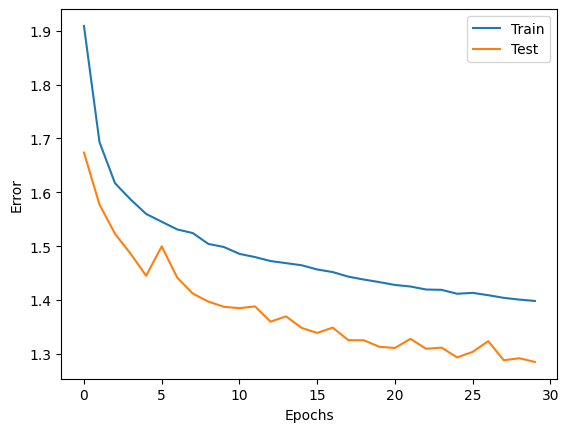

In [17]:
plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")

plt.show()

In [18]:
correct = 0
total = 0
net.eval()
for i, (x,t) in enumerate(test_loader):
  x,t = x.cuda(),t.cuda()
  y = net(x)
  correct += (y.argmax(1) ==t ).sum().item()
  total += len(x)
print("correct rate:", str(correct/total *100) +"%")

correct rate: 53.449999999999996%


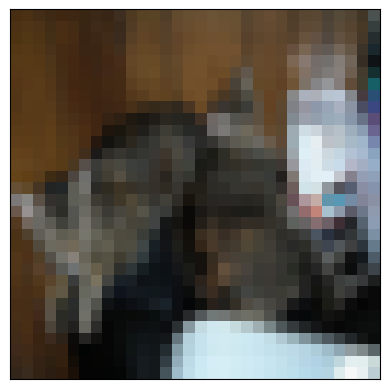

right answer: cat prediction: cat


In [24]:
cifar10_loader = DataLoader(cifar10_test,
                            batch_size=1, shuffle=True)
dataiter = iter(cifar10_loader)
images, labels = dataiter.__next__()

plt.imshow(images[0].permute(1,2,0))
plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)#undisplay label and memory
plt.show()

net.eval
x, t = images.cuda(), labels.cuda()
y = net(x)
print("right answer:", cifar10_classes[labels[0]], "prediction:", cifar10_classes[y.argmax().item()])